In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import metpy
from scipy.fftpack import * 

## 2D DCT get 1D spectrum
按照Denis 2002的方法进行2D dct的谱合并，制作1D谱分析

## 2021.07.26 renew
修正了DCTN的方法，用正交的方法，检查平均值和0，0位置的谱；具体见denis 2002对于谱方差的计算，以及修改后绘制的振幅（对方差开方）

添加ERA5I的动能谱

## 数据读入

In [22]:
ke_sum = {}
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['rcm'] = ds_ke_sum['vertical integration Ke']

dir_out = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['vr'] = ds_ke_sum['vertical integration Ke']

dir_out = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['era5i'] = ds_ke_sum['vertical integration Ke']

# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
var_rmnan = {}
var_rmnan['vr'] = ke_sum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
var_rmnan['rcm'] = ke_sum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
var_rmnan['era5i'] = ke_sum['era5i'].interpolate_na(dim = 'lon', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [43]:
# 修改ERA5I coords
# var_rmnan['era5i'] = var_rmnan['era5i'].rename({"time":"Time", "lon":"longitude", "lat":"latitude"})
# var_rmnan['era5i']._coords = var_rmnan['rcm']._coords
right_era5i_time = var_rmnan['rcm'].Time.loc[var_rmnan['rcm'].Time.dt.month.isin([4,5,6,7,8])]
var_rmnan['era5i'] = var_rmnan['era5i'].assign_coords({"Time":right_era5i_time})
var_rmnan['era5i'] = var_rmnan['era5i'].assign_coords({"latitude":var_rmnan['rcm'].latitude})
var_rmnan['era5i'] = var_rmnan['era5i'].assign_coords({"longitude":var_rmnan['rcm'].longitude})

In [187]:
# 选取数据范围
sel_dict = {}
month_sel_vr  = var_rmnan['vr'].Time.dt.month.isin([6,7,8])
month_sel_rcm = var_rmnan['rcm'].Time.dt.month.isin([6,7,8])
month_sel_era5i = var_rmnan['era5i'].Time.dt.month.isin([6,7,8])

lat = var_rmnan['vr'].latitude
lon = var_rmnan['vr'].longitude
sel_dict['latitude'] = lat[(lat>=20) & (lat<=50)]
sel_dict['longitude'] = lon[(lon>=100) & (lon<=140)]
# sel_dict['latitude'] = lat#[(lat>=20) & (lat<=50)]
# sel_dict['longitude'] = lon#[(lon>=100) & (lon<=140)]

var_sel = {}
sel_dict['Time'] = month_sel_vr
var_sel['vr']  = var_rmnan['vr'].loc[sel_dict]
sel_dict['Time'] = month_sel_rcm
var_sel['rcm'] = var_rmnan['rcm'].loc[sel_dict]
sel_dict['Time'] = month_sel_era5i
var_sel['era5i'] = var_rmnan['era5i'].loc[sel_dict]



# 添加区域对角线长度
# diagonal_length = 7935. # km largescale
diagonal_length = 4840. # km smallscale


## DCTN

In [200]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
dctn_3d = {}
dctn_3d['vr'] = dctn(var_sel['vr'].values, type = 2, axes = [1,2], norm = 'ortho')
dctn_3d['rcm'] = dctn(var_sel['rcm'].values, type = 2, axes = [1,2], norm = 'ortho')
dctn_3d['era5i'] = dctn(var_sel['era5i'].values, type = 2, axes = [1,2], norm = 'ortho')

# 添加维度参数
ntime = dctn_3d['vr'].shape[0]
nlat  = dctn_3d['vr'].shape[1]
nlon  = dctn_3d['vr'].shape[2]

## DCTN CHECK

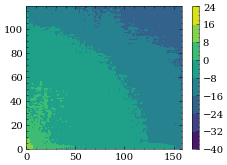

In [201]:
# 简单检查2D谱 (绘制方差)
plt.contourf(np.log(np.abs(dctn_3d['era5i'][:,:].mean(axis=0)**2)))
plt.colorbar()

In [202]:
# 平均对应谱的0，0位置的系数
# domain_avg 应该和 spectrum_coef 保持一致，为此调整了 DCT 的 norm = 'ortho' 参数，让这个条件满足
domain_avg = var_sel['vr'][0,:,:].values.mean()
spectrum_coef = dctn_3d['vr'][0, 0, 0] / np.sqrt(nlat) / np.sqrt(nlon)
spectrum_coef  - domain_avg
# domain_avg # 252.37

0.0

## 从2D谱方位角求和获得1D谱

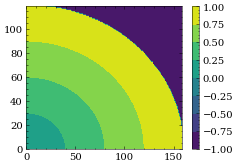

In [203]:
# 仿照denis2002进行2d alpha的预估
# nlat = 160 (miner)
# nlon = 280
Y, X     = np.ogrid[0:nlat, 0:nlon]
r        = np.hypot(X, Y).astype(np.int)
# 2D normalize wavenumber
alpha_2d =  np.empty(shape=r.shape)
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        alpha_2d[ilat, ilon] = np.sqrt( ilon**2/nlon**2 + ilat**2/nlat**2 )

# 用于确定bins的1D谱
alpha_1d = np.arange(1,nlat+1, 1) / nlat
# domain_lon_range = 3839. # km
# domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
delta = diagonal_length / nlon
# 去除掉alpha_2d中大于1的部分
alpha_2d = np.where(alpha_2d<=1, alpha_2d, -1)
plt.contourf(alpha_2d)
plt.colorbar()

In [204]:
# 按照alpha进行bins，合并2d谱为1d谱，预先进行谱的时间平均
variance_1d = {}
variance_1d['vr'] =  np.zeros(shape=[nlat])
variance_1d['rcm'] =  np.zeros(shape=[nlat])
variance_1d['era5i'] =  np.zeros(shape=[nlat])

variance_2d = {} # 时间平均???如何平均，平均系数还是平均方差
#  先进行系数的平均，在计算variance
variance_2d['vr'] = (dctn_3d['vr']).mean(axis=0)**2 /nlat /nlon
variance_2d['rcm'] = (dctn_3d['rcm']).mean(axis=0)**2 /nlat /nlon
variance_2d['era5i'] = (dctn_3d['era5i']).mean(axis=0)**2 /nlat /nlon
# 先计算variance，再计算系数的平均
# variance_2d['vr'] = (dctn_3d['vr']**2).mean(axis=0) /nlat /nlon
# variance_2d['rcm'] = (dctn_3d['rcm']**2).mean(axis=0) /nlat /nlon


for i in range(0, nlat - 1):
    sel_index  = (alpha_2d >= alpha_1d[i]) & (alpha_2d < alpha_1d[i + 1])
    # mean or sum???
    # variance_1d['vr'][i] = variance_2d['vr'][sel_index].mean()
    # variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].mean()
    # 方位角积分
    variance_1d['vr'][i] = variance_2d['vr'][sel_index].sum()
    variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].sum()
    variance_1d['era5i'][i] = variance_2d['era5i'][sel_index].sum()

In [205]:
# 进行三点平滑
# variance_1d['vr']
N = variance_1d['vr'].shape[0]
variance_1d_filter = {}
variance_1d_filter['vr'] = np.empty(N//2)
variance_1d_filter['rcm'] = np.empty(N//2)
variance_1d_filter['era5i'] = np.empty(N//2)
for i in range(0, N//2):
    variance_1d_filter['vr'][i] = variance_1d['vr'][i*2] + 0.5 * variance_1d['vr'][i*2 - 1] + 0.5 * variance_1d['vr'][i*2 + 1]
    variance_1d_filter['rcm'][i] = variance_1d['rcm'][i*2] + 0.5 * variance_1d['rcm'][i*2 - 1] + 0.5 * variance_1d['rcm'][i*2 + 1]
    variance_1d_filter['era5i'][i] = variance_1d['era5i'][i*2] + 0.5 * variance_1d['era5i'][i*2 - 1] + 0.5 * variance_1d['era5i'][i*2 + 1]

## 绘图部分

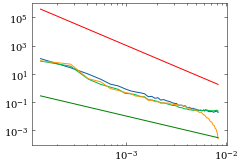

In [206]:
xf_waven = 1./(2*delta / alpha_1d)[0:N//2]
plt.plot(xf_waven, np.sqrt(variance_1d_filter['vr']))
plt.plot(xf_waven, np.sqrt(variance_1d_filter['rcm']))
plt.plot(xf_waven, np.sqrt(variance_1d_filter['era5i']))
# plt.plot(xf_waven, variance_1d_filter)
yref_synop = xf_waven[0:nlat//2] ** (-3.) * 1e-6
yref_meso  = xf_waven[0:nlat//2] ** (-5./3) * 1e-7
plt.plot(xf_waven[0:nlat//2], yref_synop,color='r')
plt.plot(xf_waven[0:nlat//2], yref_meso,color='g')
plt.yscale('log')
plt.xscale('log')

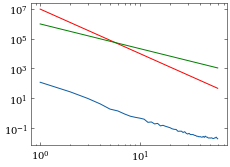

In [207]:
# np.unique(r)
# plt.plot(np.unique(r),np.abs(psd1D))
plt.plot(np.arange(1,nlat//2+1), np.sqrt(variance_1d_filter['vr']))
xf = np.arange(1,nlat)
yref_synop = xf[0:nlat//2] ** (-3.) * 1e7
yref_meso  = xf[0:nlat//2] ** (-5./3) * 1e6
plt.plot(xf[0:nlat//2], yref_synop,color='r')
plt.plot(xf[0:nlat//2], yref_meso,color='g')
plt.yscale('log')
plt.xscale('log')

<ipython-input-208-ebe240e3ff54>:40: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / x )/ domain_lon_range


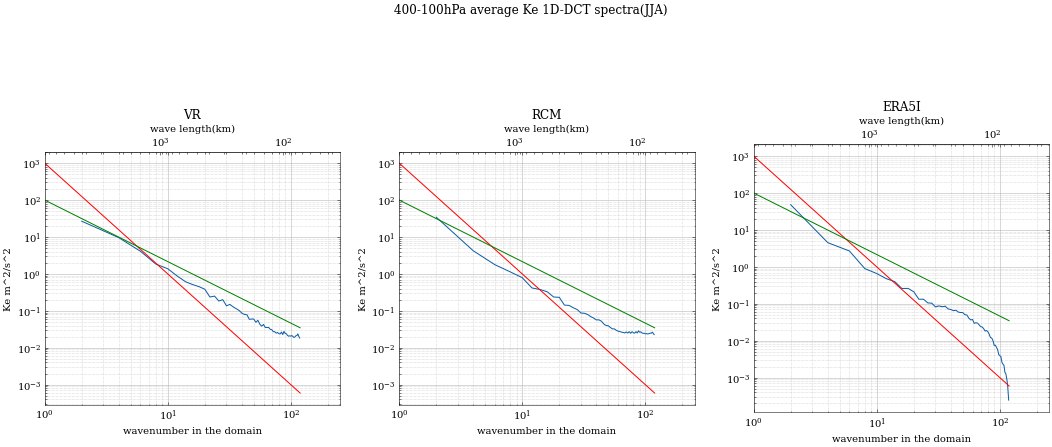

In [208]:
fig, axs = plt.subplots(1,3,figsize=(18, 8))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs[0].plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
xf = np.arange(1,nlat)
xaxis = xf[1::2]
axs[0].plot(xaxis, np.sqrt(variance_1d_filter['vr'])[1:])
# add reference line 
yref_synop = xf ** (-3.) * 1e3
yref_meso  = xf ** (-5./3) * 1e2
axs[0].plot(xf, yref_synop,color='r')
axs[0].plot(xf, yref_meso,color='g')

# 计算平均、平滑后的DCT方差
axs[1].plot(xaxis, np.sqrt(variance_1d_filter['rcm'])[1:])
# add reference line
yref_synop = xf ** (-3.) * 1e3
yref_meso  = xf ** (-5./3) * 1e2
axs[1].plot(xf, yref_synop,color='r')
axs[1].plot(xf, yref_meso,color='g')

# 计算平均、平滑后的DCT方差
axs[2].plot(xaxis, np.sqrt(variance_1d_filter['era5i'])[1:])
# add reference line
yref_synop = xf ** (-3.) * 1e3
yref_meso  = xf ** (-5./3) * 1e2
axs[2].plot(xf, yref_synop,color='r')
axs[2].plot(xf, yref_meso,color='g')


def upper_xaxis(x):
    # domain_lon_range = 3829. # km
    domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
    return domain_lon_range / x

def upper_xaxis_inv(x):
    # domain_lon_range = 3839. # km
    domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
    return (1. / x )/ domain_lon_range 

for axs_ind in axs:
    axs_ind.set_yscale('log')
    axs_ind.set_xscale('log')
    upper_axs_ind = axs_ind.secondary_xaxis('top', functions = (upper_xaxis, upper_xaxis_inv) )
    upper_axs_ind.set_xticks([])
    upper_axs_ind.set_xlabel('wave length(km)')
    axs_ind.xaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.xaxis.grid(True, which="major", linestyle = "-")
    axs_ind.yaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.yaxis.grid(True, which="major", linestyle = "-")

    axs_ind.set_xlabel('wavenumber in the domain')
    axs_ind.set_ylabel('Ke m^2/s^2')
    axs_ind.set_xlim([10**0, 10**(2.4)])
    axs_ind.set_aspect(0.3, 'box')

axs[0].set_title('VR')
axs[1].set_title('RCM')
axs[2].set_title('ERA5I')
# axs[0].legend()
# axs[1].set_xlim([1e-5,1e-4])
# keep plot square
# save fig
fig.suptitle("400-100hPa average Ke 1D-DCT spectra(JJA)")
plt.savefig('./output_pic/ke_spectral_addera5i_largedomain.png', dpi=300, facecolor= "white")

<ipython-input-209-c9578f46681a>:29: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / x )/ domain_lon_range


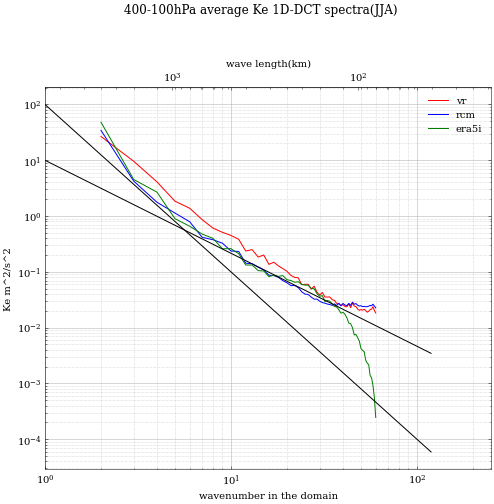

In [209]:
fig, axs = plt.subplots(1,1,figsize=(8, 8))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs.plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
xf = np.arange(1,nlat)
xaxis = xf[1:N//2]
axs.plot(xaxis, np.sqrt(variance_1d_filter['vr'])[1:], label='vr', color='r')
axs.plot(xaxis, np.sqrt(variance_1d_filter['rcm'])[1:], label='rcm', color = 'b')
axs.plot(xaxis, np.sqrt(variance_1d_filter['era5i'])[1:], label='era5i', color = 'g')
# add reference line 
yref_synop = xf ** (-3.) * 1e2
yref_meso  = xf ** (-5./3) * 1e1
axs.plot(xf, yref_synop,color='k')
axs.plot(xf, yref_meso,color='k')



def upper_xaxis(x, diagonal_length = diagonal_length):
    # domain_lon_range = 4840. # km
    domain_lon_range = diagonal_length # km
    # domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
    return domain_lon_range / x

def upper_xaxis_inv(x, diagonal_length = diagonal_length):
    # domain_lon_range = 4840. # km
    domain_lon_range = diagonal_length # km
    # domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
    return (1. / x )/ domain_lon_range 

axs_ind = axs
axs_ind.set_yscale('log')
axs_ind.set_xscale('log')
upper_axs_ind = axs_ind.secondary_xaxis('top', functions = (upper_xaxis, upper_xaxis_inv) )
upper_axs_ind.set_xticks([])
upper_axs_ind.set_xlabel('wave length(km)')
axs_ind.xaxis.grid(True, which="minor", linestyle = ":")
axs_ind.xaxis.grid(True, which="major", linestyle = "-")
axs_ind.yaxis.grid(True, which="minor", linestyle = ":")
axs_ind.yaxis.grid(True, which="major", linestyle = "-")

axs_ind.set_xlabel('wavenumber in the domain')
axs_ind.set_ylabel('Ke m^2/s^2')
axs_ind.set_xlim([10**0, 10**(2.4)])
axs_ind.set_aspect(0.3, 'box')
axs_ind.legend()
# axs.set_title('VR')
# axs[1].set_title('RCM')
# axs[2].set_title('ERA5I')
# axs.legend()
# axs[1].set_xlim([1e-5,1e-4])
# keep plot square
# save fig
fig.suptitle("400-100hPa average Ke 1D-DCT spectra(JJA)")
plt.savefig('./output_pic/ke_spectral_addera5i_smalldomain.png', dpi=300, facecolor= "white")